# 8.1 序列模型

### 8.1.2 训练

In [16]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

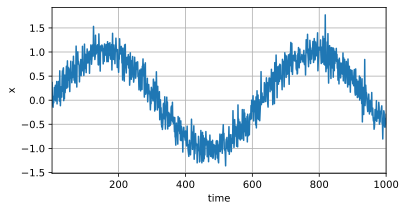

In [30]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
# 生成相关数据 并增加了一些随机噪声
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [18]:
# 使用前600个特征进行训练
tau = 4
# 生成标签数据
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

### 标签生成方法
1. 序列预测
在时间序列预测任务中，模型的目标是根据过去的观测值来预测未来的值。通过这种方式生成特征和标签，可以让模型学习到时间序列数据中的模式和趋势。

2. 滑动窗口方法
使用滑动窗口方法生成特征和标签，有助于创建多个训练样本，从而增强模型的泛化能力。每个窗口包含一组连续的时间步长数据，模型可以通过这些窗口学习到序列数据的时间依赖关系。

3. 时间依赖关系
时间序列数据通常具有时间依赖性，即未来的值依赖于过去的观测值。通过这种方式生成特征和标签，可以捕捉到时间序列数据中的时间依赖关系，使模型能够更准确地进行预测。

4. 增强数据集
生成的特征和标签有助于增强数据集的大小，从而提高模型的训练效果。更多的训练样本可以帮助模型更好地学习数据中的模式，减少过拟合的风险。

5. 简化模型输入
这种方法将时间序列数据转换为固定大小的输入，使得模型可以处理不同长度的时间序列数据。通过将输入和输出固定为相同的大小，可以简化模型的设计和实现。

In [15]:
x = torch.arange(10, dtype=torch.float32)  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
T = len(x)  # 10
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
print(features)

tensor([[0., 1., 2., 3.],
        [1., 2., 3., 4.],
        [2., 3., 4., 5.],
        [3., 4., 5., 6.],
        [4., 5., 6., 7.],
        [5., 6., 7., 8.]])


In [19]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [29]:
# 查看样本与标签的形状
x,y = next(iter(train_iter))
print(x.shape, y.shape)
# 前边设置了tau = 4 所以x的形状是(批次大小,时间步数=4)

torch.Size([16, 4]) torch.Size([16, 1])


In [21]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [22]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.109888
epoch 2, loss: 0.080180
epoch 3, loss: 0.068810
epoch 4, loss: 0.065076
epoch 5, loss: 0.062666


## 8.1.3 预测

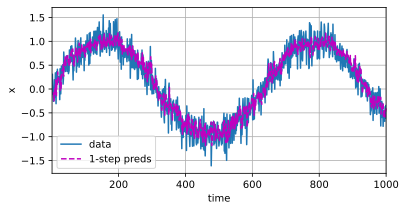

In [23]:
# 单步预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

In [24]:
# 多步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

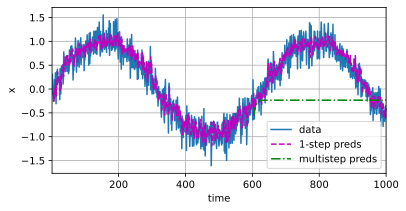

In [25]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [26]:
max_steps = 64

In [27]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

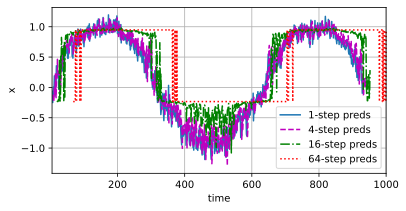

In [28]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))